# Machine Vision and Cognitive Robotics - Exercise 4

<!-- 
Automation and Control Institute - TU Wien
Matthias Hirschmanner 2021
machinevision@acin.tuwien.ac.at
 -->

In this exercise you will implement a neural network to classify images of the CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). It consists of 60000 images with a resolution of 32x32. The different classes and example images for each classes are shown in Figure 1 below. We will use the library PyTorch to create and train neural networks.


![Classes of CIFAR10](https://owncloud.tuwien.ac.at/index.php/apps/files_sharing/ajax/publicpreview.php?x=1064&y=425&a=true&file=ex4_cifar10_2.png&t=PfJAai8huq9AWRa)

Figure 1: Examples of the different classes of the CIFAR10 dataset.

---



Please keep the code in the sections below clean and only change it in the dedicated areas. You shouldn't need to change it anywhere else. You also shouldn't need to use any additional libraries other than the ones already imported. If you need to change the code somewhere else or need to import a different library to get a functioning program, that might be a bug. Please report it in the Tuwel forum or send us a mail to machinevision@acin.tuwien.ac.at


## Import Libraries
In a first step we import the libraries needed for the exercise. Please execute the cell below.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import random
import requests
import imageio
from PIL import Image
from typing import List

import torch
import torchvision
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import os
from typing import Tuple

os.environ['KMP_DUPLICATE_LIB_OK']='True'
get_ipython().__class__.__name__ = "ZMQInteractiveShell"

print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
if torch.cuda.is_available():
    print('Device:', torch.cuda.get_device_name(0))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))



Torch 1.10.0+cu111 CUDA 11.1
Device: Tesla K80
Using cuda device


After executing this cell, it should show that you are using a "cuda" device. This means you can run code on the GPU. If this is not the case, change the runtime to GPU.

**Edit 23.11.2021: Since Google Colab seems to be a bit more restrictive with the GPU than in previous years, I recommend to do the first parts of the exercise only with CPU and switch to GPU once you train your CNN model (7. Convolutional Neural Network).** 

## PyTorch
The first step of the exercise is mainly aimed at getting familiar with the PyTorch library and how it works. We will use it to define and train neural networks. The main data structure of PyTorch are tensors. They are very similar to NumPy arrays, but can run on GPUs or other hardware accelerators. Tensors are optimized for automatic differentiation which we will use for gradient descent to optimize the parameters/weights of an network. 

In [ ]:
# Demo of creating a tensor from a numpy array and then moving it to the GPU.
a_np = np.array([[1,2],[3,4]])
print(a_np)
a_t = torch.from_numpy(a_np)
print(a_t)
a_t_gpu = a_t.to('cuda')
print(a_t_gpu)

b_np = np.array([[1,2],[3,4]])
b_t = torch.from_numpy(a_np)

# This would not work, because b_t is on the CPU and a_t on the GPU
# print(b_t*a_t_gpu)

print(b_t.to(device)*a_t_gpu)

[[1 2]
 [3 4]]
tensor([[1, 2],
        [3, 4]])
tensor([[1, 2],
        [3, 4]], device='cuda:0')
tensor([[ 1,  4],
        [ 9, 16]], device='cuda:0')


When we apply functions on our tensors, PyTorch (or more specifically autograd) keeps a record of all tensors, operations and resulting new tensors in a directed acyclic graph (DAG) also called the Computational Graph. It also supports automatically calculating the gradients of all tensors using backpropagation (which is the fancy term to apply the chain rule). For an introduction to these computational graphs and how to calculate gradients, see https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html. For a good introduction to backpropagation, you can watch this video which is also linked in the tutorial above: https://youtu.be/tIeHLnjs5U8 

##1. Linear Regression and Gradient Descent (2 Points)
As a first step to get to know PyTorch and using its automatic differentiation engine, you will implement linear regression with a neural network. Linear regression refers to the method of fitting a linear model to approximate some input data. In other words, we want to find the coefficients of a function $w_1x_1+w_2x_2+\dots +w_nx_n+b=y$ to minimize the distance of our input data to the estimated values. There are many methods that are better suited to solve this problem, e.g. Least Squares or RANSAC (which we will implement in exercise 5). However, to get familiar with neural networks, we will solve this task with a 1 layer neural network and Gradient Descent. The network is shown in Figure 2.

Implement the function `linear_regression` which takes as input the array $\mathbf{X}$ and vector $\mathbf{y}$ and returns the coefficients of the linear model $(w_1,w_2,\dots,w_n,b)^T$. You should perform gradient descent to minimize the loss function to estimate these coefficients. As a loss function, use the (mean) squared distance. You should use tensors and the PyTorch's autograd engine. Do not use a built-in optimizer, but implement a simple gradient descent yourself. 

Tipp: When updating the weights/coefficients use `with torch.no_grad():`, otherwise PyTorch will also keep track of these functions and its gradients. After updating the weights with the gradients, set them to 0, otherwise PyTorch adds up future gradients.	

![Linear Model](https://owncloud.tuwien.ac.at/index.php/apps/files_sharing/ajax/publicpreview.php?x=1023&y=400&a=true&file=ex4_linearmodel.png&t=A4cyYi3Lgrp1MXM&scalingup=0)

Figure 2: Linear model visualized as a one layer neural network.

---

In [ ]:
def linear_regression(x_in: np.ndarray, 
                      y_in: np.ndarray, 
                      learning_rate: float = 0.01,
                      epochs: int = 30) -> Tuple[np.ndarray, np.ndarray]:
  """ Calculate the coefficients of the linear model w1x1+w2x2+...+wnxn+b = y
      to fit the input data using gradient descent. 

  :param x_in: The independent variables x. Each row is related to one datapoint.
  :type x_in: np.ndarray with shape (data_points, nr. of independent variables)

  :param x_in: The dependent variable y. Each row is related to one datapoint.
  :type x_in: np.ndarray with shape (data_points, 1)

  :param learning_rate: The coefficient to update the weights per gradient 
    descent iteration.
  :type learning_rate: float in (0,1)

  :param epochs: Number of times the whole dataset is used for gradient descent-
  :type epochs: int > 0

  :return: (coefficients, loss_history)
    coefficients: The coefficients of the linear model (w1,w2,...,wn,b)
    loss_history: Array with the mean squared loss per epoch. 
  :rtype: 
    coefficients: np.ndarray (w1,w2,...,wn,b) with shape (nr. of ind. variables + 1,)
    loss_history: np.ndarray (loss_ep1, loss_ep2, ... loss_epn) with shape (epoch,)
  """
  ###################################
  
  # Initializes the weights and the bias to zero and transfers them to the GPU. 
  # I also transform the x_in and the y_in into tensors for calculations 

  w = np.zeros((x_in.shape[1], 1)).reshape(-1)
  w_t = torch.from_numpy(w)
  w_t.requires_grad = True
  y_in_t = torch.from_numpy(y_in)
  x_in_t = torch.from_numpy(x_in)
  loss_hist = []
  b = torch.tensor(0.,requires_grad=True)

  for epoch in range(epochs):
    # Calculate the predictions 
    y_pred = torch.matmul(x_in_t, w_t) + b
 
    # Calculate the loss and append it to my history-list of losses
    loss = torch.square(y_pred - y_in_t).mean()
    loss_hist.append(loss)

    # Calculates as well as updates the weights and the bias
    loss.backward()
    with torch.no_grad():
      w_t  -= (w_t.grad * learning_rate)
      b  -= (b.grad * learning_rate)
      w_t.grad.zero_()
      b.grad.zero_()

  # Transform the weights and the bias into numpy-arrays to return
  w = w_t.detach().numpy()
  b = b.detach().numpy()
  coefficients = np.r_[w, b]
  losses = np.array(loss_hist)

  ###################################
  return coefficients, losses

Below we apply your linear regression algorithm. You might need to change the learning rate or the number of epochs to get good results, depending on the details of your implementation.

<Figure size 432x288 with 0 Axes>

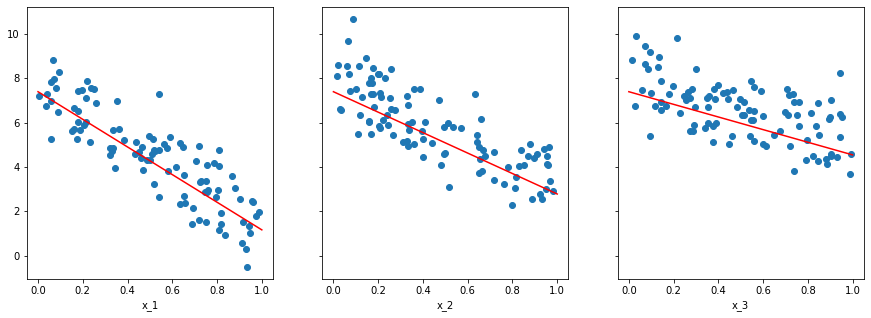

In [ ]:
# Adapt these parameters if necessary
learning_rate = 0.01
epochs = 5000

# Generate random data 
x_in = np.random.rand(100, 3)

# Extend with ones to add the constant factor in one operation
x_in_homogeneous = np.c_[x_in, np.ones(100)]

# Generate random coefficients w1, w2, w3, b
coeff_in = np.random.randint(-10, 10, 4)

# Generate noise from a Normal Distribution. 
# Might be helpful to repmove noise for debugging
noise = np.random.randn(100)

# Calculate y
y_in = np.dot(x_in_homogeneous, coeff_in) + noise

# Apply linear regression
# Depending on your implementation, you might need to change your learning rate!
coefficients, losses = linear_regression(x_in, 
                                         y_in, 
                                         learning_rate = learning_rate,
                                         epochs = epochs)

# Plot the output per dimension
f = plt.figure()    
f, axes = plt.subplots(nrows = 1, 
                       ncols = x_in.shape[1], 
                       sharex= True, 
                       sharey = True,
                       figsize=(15,5))

t = np.array([0,1])


axes[0].scatter(x_in[:,0], 
                x_in[:,0] * coeff_in[0] + coeff_in[3] + noise, 
                marker = "o")
axes[0].plot(t, t * coefficients[0] + coefficients[3], color = 'red')
axes[0].set_xlabel('x_1')

axes[1].scatter(x_in[:,1], 
                x_in[:,1] * coeff_in[1] + coeff_in[3] + noise, 
                marker = "o")
axes[1].plot(t, t * coefficients[1] + coefficients[3], color = 'red')
axes[1].set_xlabel('x_2')

axes[2].scatter(x_in[:,2], 
                x_in[:,2] * coeff_in[2] + coeff_in[3] + noise, 
                marker = "o")
axes[2].plot(t, t * coefficients[2] + coefficients[3], color = 'red')
axes[2].set_xlabel('x_3')


plt.show()

## Load Dataset
In this exercise we will experiment with different neural networks to classify the images of the CIFAR10 dataset. First, we load the CIFAR10 dataset. The training images are in `trainset` and the test images in `testset`. We also create dataloaders for both sets. For more information how to use the datasets and dataloaders you can check https://pytorch.org/tutorials/beginner/basics/data_tutorial.html. 


In [ ]:
# Load datasets, I've added in the normalization here which I calculate further down.

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transforms.Compose([transforms.ToTensor(), 
                                                                       transforms.Normalize((0.49139968, 0.48215827, 0.44653124), 
                                                                                            (0.24703233, 0.24348505, 0.26158768))]))
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=128,
                                          shuffle=True, 
                                          pin_memory = True, 
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       #transform=transforms.ToTensor()
                                       transform=transforms.Compose([transforms.ToTensor(), 
                                                                       transforms.Normalize((0.49139968, 0.48215827, 0.44653124), 
                                                                                            (0.24703233, 0.24348505, 0.26158768))]))
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=1024,
                                         shuffle=False, 
                                         pin_memory = True, 
                                         num_workers=2)

# The classes are:
# 0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 
# 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'

Files already downloaded and verified
Files already downloaded and verified


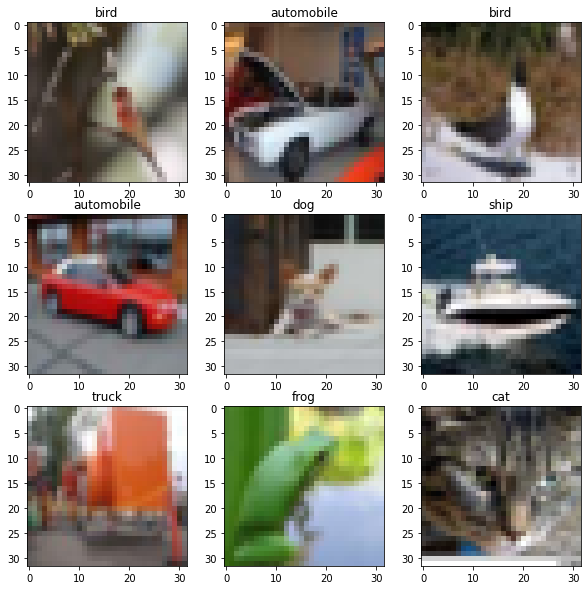

In [ ]:
#@title Run this cell!
#@markdown It will show you 9 random images of the dataset. 
#@markdown The code itself is not relevant, but it is important for later to execute this cell because some plotting functions are defined here. 
fig, axs = plt.subplots(3, 3,figsize=(10,10))
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
random_indices = np.random.randint(testset.data.shape[0], size=9)
for (idx,ax) in zip(random_indices,axs.flat):
  ax.set_title(labels[testset.targets[idx]])
  ax.imshow(testset.data[idx])


def plot_predictions(dataloader: torch.utils.data.DataLoader,
                     model_name: torch.nn.Module,
                     class_name: str = None,
                     sort_predictions: bool = False,
                     num_batches: int = np.inf):
    """ Plot the predictions for some random images. If class_name is set, it will be images of this class

    :param dataloader: The dataloader you want to to load the images
    :type dataloader: torch.utils.data.DataLoader

    :param model_name: Your PyTorch module you want to use to predict labels
    :type model_name: torch.nn.Module

    :param class_name: Define if you are interested in the predictions of one specific class, e.g. "dog"
    :type class_name: str

    :param sort_predictions: If True, plots the images with the highest prediction values. Otherwise random
    :type sort_predictions: bool

    :param num_batches: The number of batches we will load with the dataloader. Can help to reduce used memory.
    :type num_batches: int

    :return: None
    :rtype: None
    """

    if num_batches <= 0:
        raise ValueError("The argument num_batches has to be above 0")

    classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse',
               8: 'ship', 9: 'truck'}
    classes_inv = {v: k for k, v in classes.items()}

    # Check which device the model is using
    if next(model_name.parameters()).is_cuda:
        device = 'cuda'
    else:
        device = 'cpu'

    # Set the model to eval() compared to train
    model_name.eval()

    # We go through our data and store it
    # (storing all the images can use a lot of memory, but should work fine for CIFAR10)
    y_predictions_tens = torch.empty([0, 10])
    y_true_tens = torch.empty([0, ])
    x_tens = torch.empty([0, 3, 32, 32])
    for batch_idx, (x, y) in enumerate(dataloader):
        with torch.no_grad():
            if batch_idx + 1 > num_batches:
                break
            pred = F.softmax(model_name(x.to(device)), dim=1)
            y_predictions_tens = torch.cat((y_predictions_tens, pred.cpu()))
            y_true_tens = torch.cat(((y_true_tens), y.cpu()))
            x_tens = torch.cat((x_tens, x))

    # Get the predicted labels for all images
    y_predictions_labels = y_predictions_tens.argmax(dim=1)

    # Get a boolean mask for all images that were correctly classified
    mask_true_predictions = (y_predictions_labels == y_true_tens)

    if class_name:
        class_number = classes_inv.get(class_name, -1)
        if class_number != -1:  # taking only predictions with defined class_name

            # Boolean Mask of images that were correctly predicted with class_name
            class_mask_correct = (y_true_tens[mask_true_predictions] == class_number)

            # Boolean Mask of images that are images of the class_name, but were wrongly predicted (false negatives)
            class_mask_false_negatives = (y_true_tens[~mask_true_predictions] == class_number)

            # Boolean Mask of images that were predicted as class_name, but are of a different class (false positives)
            class_mask_false_positives = (y_predictions_labels[~mask_true_predictions] == class_number)

            print('Number of correct recognized', class_name, 'images is', class_mask_correct.sum().numpy())
            print('Number of images recognized as', class_name, 'but are not of that class is',
                  class_mask_false_positives.sum().numpy())
            print('Number of images not recognized as', class_name, 'but actually are of that class is',
                  class_mask_false_negatives.sum().numpy())
        else:
            print('No such class like', class_name + '. Check class name again.')
    else:
        print('Number of correct recognized images:', mask_true_predictions.sum().numpy())
        print('Number of wrong recognized images:', (~mask_true_predictions).sum().numpy())

    images_per_row = 10  # Number of images we want to plot per row
    if class_name:
        if class_number != -1:
            fig = plt.figure(figsize=(20, 7.5))

            ######################################################################################################
            # First we want to plot images that were correctly classified

            # We sample indices of the images to plot.
            # If sort_predictions = True, we will plot the images with the highest prediction value
            if sort_predictions:
                idx_correct_sorted = y_predictions_tens[mask_true_predictions][class_mask_correct].max(
                    dim=1).values.argsort(descending=True)
                idx_correct = idx_correct_sorted[:images_per_row]

            # If sort_predictions = False, we sample random indices
            else:
                perm = torch.randperm(class_mask_correct.sum())
                idx_correct = perm[:images_per_row]

            # Apply our generated Boolean masks to get the sampled images that were correctly identified
            x_samples = x_tens[mask_true_predictions][class_mask_correct][idx_correct]

            # Get the predicted class number (if we did everything correct, it should only return class_number)
            y_samples = y_predictions_labels[mask_true_predictions][class_mask_correct][idx_correct]

            # Get the Softmax prediction values of the sampled images
            y_prediction_samples = y_predictions_tens[mask_true_predictions][class_mask_correct][idx_correct]

            # Get the max value of the prediction values
            # y_prediction_right_samples = y_prediction_samples[range(len(y_samples)), y_samples]
            y_prediction_samples_max = y_prediction_samples.max(dim=1).values

            # Plot it
            for idx in range(len(x_samples)):
                a = fig.add_subplot(3, 10, idx + 1)
                imgplot = plt.imshow(transforms.ToPILImage()(x_samples[idx]))
                a.set_title(
                    classes[int(y_samples[idx])] + "\n p=" + str(y_prediction_samples_max[idx].numpy().round(4)),
                    color='green',
                    y=-0.3)
                a.axis('off')

            ######################################################################################################
            # Next, we want to plot false positives - Images that are classified as the specific class,
            # but actually belong to a different class.

            # We sample indices of the images to plot.
            # If sort_predictions = True, we will plot the images with the highest prediction value
            if sort_predictions:
                idx_false_positive_sorted = y_predictions_tens[~mask_true_predictions][
                    class_mask_false_positives].max(dim=1).values.argsort(descending=True)
                idx_false_positive = idx_false_positive_sorted[:images_per_row]

            # If sort_predictions = False, we sample random indices
            else:
                perm = torch.randperm(class_mask_false_positives.sum())
                idx_false_positive = perm[:images_per_row]

            # Apply our generated Boolean masks to get the sampled images that are false positives
            x_samples = x_tens[~mask_true_predictions][class_mask_false_positives][idx_false_positive]

            # Get the predicted class number (if we did everything correct, it should only return class_number)
            y_samples = y_predictions_labels[~mask_true_predictions][class_mask_false_positives][idx_false_positive]

            # Get the Softmax prediction values of the sampled images
            y_prediction_samples = y_predictions_tens[~mask_true_predictions][class_mask_false_positives][
                idx_false_positive]

            # Get the max value of the prediction values
            # y_prediction_samples_max = y_prediction_samples[range(len(y_samples)), y_samples] # Does the same
            y_prediction_samples_max = y_prediction_samples.max(dim=1).values

            # Plot it
            for idx in range(len(x_samples)):
                a = fig.add_subplot(3, 10, idx + images_per_row + 1)
                imgplot = plt.imshow(transforms.ToPILImage()(x_samples[idx]))
                a.set_title(
                    classes[int(y_samples[idx])] + "\n p=" + str(y_prediction_samples_max[idx].numpy().round(4)),
                    color='red',
                    y=-0.3)
                a.axis('off')

            ######################################################################################################
            # Next, we want to plot false negatives - Images that are of the specific class,
            # but were classified as a different class.

            # We sample indices of the images to plot.
            # If sort_predictions = True, we will plot the images with the highest prediction value
            if sort_predictions:
                idx_false_negatives_sorted = y_predictions_tens[~mask_true_predictions][
                    class_mask_false_negatives].max(dim=1).values.argsort(descending=True)
                idx_false_negatives = idx_false_negatives_sorted[:images_per_row]
            else:
                perm = torch.randperm(class_mask_false_negatives.sum())
                idx_false_negatives = perm[:images_per_row]

            # Apply our generated Boolean masks to get the sampled images that are false negatives
            x_samples = x_tens[~mask_true_predictions][class_mask_false_negatives][idx_false_negatives]

            # Get the predicted class number
            y_samples = y_predictions_labels[~mask_true_predictions][class_mask_false_negatives][
                idx_false_negatives]

            # Get the Softmax prediction values of the sampled images
            y_prediction_samples = y_predictions_tens[~mask_true_predictions][class_mask_false_negatives][
                idx_false_negatives]

            # Get the max value of the prediction values
            # y_prediction_samples_max = y_prediction_samples[range(len(y_samples)), y_samples] # Does the same
            y_prediction_samples_max = y_prediction_samples.max(dim=1).values

            # Plot it
            for idx in range(len(x_samples)):
                a = fig.add_subplot(3, 10, idx + 2 * images_per_row + 1)
                imgplot = plt.imshow(transforms.ToPILImage()(x_samples[idx]))
                a.set_title(
                    classes[int(y_samples[idx])] + "\n p=" + str(y_prediction_samples_max[idx].numpy().round(3)),
                    color='red',
                    y=-0.3)
                a.axis('off')
            ######################################################################################################

            plt.figtext(0.5, 0.88, "Correct Predictions", ha="center", va="top", fontsize=14)
            plt.figtext(0.5, 0.61, "False Positives", ha="center", va="top", fontsize=14)
            plt.figtext(0.5, 0.34, "False Negatives", ha="center", va="top", fontsize=14)

    # If no class_name was given, plot random images of all classes
    else:

        ######################################################################################################
        # First we want to plot images that were correctly classified

        # We sample indices of the images to plot.
        # If sort_predictions = True, we will plot the images with the highest prediction value
        fig = plt.figure(figsize=(20, 5))
        if sort_predictions:
            idx_correct_sorted = y_predictions_tens[mask_true_predictions].max(dim=1).values.argsort(
                descending=True)
            idx_correct = idx_correct_sorted[:images_per_row]

        # If sort_predictions = False, we sample random indices
        else:
            perm = torch.randperm(mask_true_predictions.sum())
            idx_correct = perm[:images_per_row]

        # Apply our generated Boolean masks to get the sampled images that were correctly identified
        x_samples = x_tens[mask_true_predictions][idx_correct]

        # Get the Softmax prediction values of the sampled images
        y_prediction_samples = y_predictions_tens[mask_true_predictions][idx_correct]

        # Get the max value of the prediction values
        y_samples_max = y_prediction_samples.max(dim=1)
        for idx in range(len(x_samples)):
            a = fig.add_subplot(2, 10, idx + 1)
            imgplot = plt.imshow(transforms.ToPILImage()(x_samples[idx]))
            a.set_title(
                classes[int(y_samples_max.indices[idx])] + "\n p=" + str(
                    y_samples_max.values[idx].numpy().round(4)),
                color='green',
                y=-0.3)
            a.axis('off')

        ######################################################################################################
        # Next we want to plot images that were classified as a different class

        # We sample indices of the images to plot.
        # If sort_predictions = True, we will plot the images with the highest prediction value
        if sort_predictions:
            idx_false_sorted = y_predictions_tens[~mask_true_predictions].max(dim=1).values.argsort(
                descending=True)
            idx_false = idx_false_sorted[:images_per_row]

        # If sort_predictions = False, we sample random indices
        else:
            perm = torch.randperm((~mask_true_predictions).sum())
            idx_false = perm[:images_per_row]

        # Apply our generated Boolean masks to get the sampled images that were correctly identified
        x_samples = x_tens[~mask_true_predictions][idx_false]

        # Get the Softmax prediction values of the sampled images
        y_prediction_samples = y_predictions_tens[~mask_true_predictions][idx_false]

        # Get the max value of the prediction values
        y_samples_max = y_prediction_samples.max(dim=1)

        for idx in range(len(x_samples)):
            a = fig.add_subplot(2, 10, idx + 11)
            imgplot = plt.imshow(transforms.ToPILImage()(x_samples[idx]))
            a.set_title(
                classes[int(y_samples_max.indices[idx])] + "\n p=" + str(
                    y_samples_max.values[idx].numpy().round(4)),
                color='red',
                y=-0.3)
            a.axis('off')

        plt.figtext(0.5, 0.88, "Correct Predictions", ha="center", va="top", fontsize=14)
        plt.figtext(0.5, 0.46, "False Predictions", ha="center", va="top", fontsize=14)

    plt.show()


# Normalization of an image and training
def predict_image(model_name, image):
  labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
  # prediction with a model
  img_torch = torch.from_numpy(np.transpose(image.astype(np.float32), (0,3,1,2))/255.)
  model_name.eval()
  test_prediction = F.softmax(model_name(img_torch.to(device)), dim=1) # define a model of nn
  # top 5 predictions
  out_ind_up = sorted(range(len(list(test_prediction[0]))), key = lambda sub: test_prediction[0][sub])[-5:] 
  # result
  
  print("Top-5 Predictions:")
  for i in out_ind_up[::-1]:
    print()
    print(' ', labels[i].capitalize(), '-', round((test_prediction[0,i].cpu().detach().numpy())*100,2), '%')
  
# Load an image from an external URL an returns it
def load_image_link(link): 
  response = requests.get(link)
  im_from_link = Image.fromarray(imageio.imread((response.content))) 
  # Adjust width and height to CIFAR10 resolution
  width = 32
  height = 32
  loaded_image = im_from_link.resize((width, height), Image.ANTIALIAS)
  loaded_image = np.expand_dims(loaded_image, axis = 0)
  return loaded_image

# Load an image from Colab folder
def load_image_colab(image_name): 
  # Default Colab folder: "/content/..."
  imageFile = "/content/" + image_name # taking a file with original size
  im_from_fold = Image.open(imageFile) # if you do it from colab folder
  # Adjust width and height to CIFAR10 resolution
  width = 32
  height = 32
  loaded_image = np.array(im_from_fold.resize((width, height), Image.ANTIALIAS))
  loaded_image = np.expand_dims(loaded_image, axis = 0)
  return loaded_image
#Function to plot the training
def plot_losses(train_losses: List, 
                test_losses: List, 
                train_accuracies: List,
                test_accuracies: List,
                title: str):

  # Plot the Training History
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
  fig.suptitle(title)
  ax1.plot(train_accuracies, label="Train")
  ax1.plot(test_accuracies, label="Test")
  ax1.set(xlabel='Epoch', ylabel='Accuracy')
  ax1.legend(loc="upper left")
  ax2.plot(train_losses, label='Train')
  ax2.plot(test_losses, label='Test')
  ax2.set(xlabel='Epoch', ylabel='Loss')
  ax2.legend(loc="upper right")


## 2. Normalize Images (1 Point)
Before we start with the classification, we want to normalize our training dataset to have approximately zero mean ($\mu=0$) and unit variance ($\sigma=1$). For this, we need to calculate the mean and standard deviation of the training dataset. Your task is to create the function `calculate_mean_std` which takes a dataset as input. The outputs should be the two tuples `mean` and `std`. Both should be calculated per color channel. Only use the standard numpy functionality to implement this function (e.g. `np.mean()`, `np.var()`, `np.std()`, etc.). These values should be in [0, 1]. This is because when training the images are automatically converted to the range [0, 1], but when accessing them via trainset.data they are in the range [0, 255]. The values you calculate with this function should be used inside of your models to normalize the input data. Feel free to calculate the values once, and then hard-code them in your models.

You can find more detailed explanation of why we do normalization in this video by Andrew Ng: [Andrew Ng - Normalizing Inputs](https://www.youtube.com/watch?v=FDCfw-YqWTE)

**IMPORTANT:** Use the same mean and and standard deviation you get from the training set also for the test set, because we want our training and test data to go through the same transformation.

In [ ]:
def calculate_mean_std(dataset: torch.utils.data.Dataset) -> Tuple[np.ndarray, np.ndarray]:
  """ Calculate the mean and standard deviation of the dataset

  :param dataset: The input dataset to calculate the mean and std of
  :type dataset: torch.utils.data.Dataset
  
  :return: (mean, std)
    mean: The mean of the dataset per color channel
    std: The standard deviation of the dataset per color channel
  :rtype: Tuple(mean, std)
    mean: Tuple with shape (3,)
    std:  Tuple with shape (3,)
  """
  ###################################

  # In this class I calculate the mean as well as the std over the three
  # color-channels which I return as tuples. These values are then hard-coded
  # Into the loading of the datasets 

  channel0 = []
  channel1 = []
  channel2 = []

  for data in dataset:
    image, label = data
    image_np = image.detach().numpy()

    channel0.append(image_np[0])
    channel1.append(image_np[1])
    channel2.append(image_np[2])

  mean = (np.mean(np.array(channel0)), np.mean(np.array(channel1)), np.mean(np.array(channel2)))
  std = (np.std(np.array(channel0)), np.std(np.array(channel1)), np.std(np.array(channel2)))

  ###################################
  return mean, std

mean , std = calculate_mean_std(trainset)
print(mean)
print(std)


(6.749868e-08, 6.0572626e-07, -1.1978435e-06)
(0.99999994, 1.0000001, 1.000001)


## 3. Loss Function (1 Point)
Implement the cross-entropy loss in the function `my_crossentropy` with the mathematical functions defined in PyTorch. Its inputs are the tensors `predictions` and `labels`. The `prediction` tensor consists of the unnormalized prediction values for each class (the output of our network). The `label` tensor holds the true label for each training image in the range [0, `nr_of_classes -1`]. The output tensor should be the mean cross entropy loss over the whole miniset `(number_of_predictions,)`. You should use the functions provided in the PyTorch e.g. `torch.sum()` (https://pytorch.org/docs/stable/generated/torch.sum.html). Don't use the built-in crossentropy loss of PyTorch. For the formulas of the cross entropy loss, you can look at the formulas here: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html. You only need to implement "mean" reduction. Do not use functions like `F.log_softmax` or `F.cross_entropy`. For debugging you can generate tensors and compare the output of your function with `F.cross_entropy`.

This video gives a good explanation about the cross-entropy loss: https://youtu.be/ueO_Ph0Pyqk

In [ ]:
def my_cross_entropy(predictions, labels):
  """ Calculate the categorical crossentropy loss between the labels and the prediction

  :param predictions: Unnormalized prediction values of classes
  :type predictions: torch.Tensor with shape (batch_size, num_classes) and dtype = torch.float32

  :param labels: The class index of each datapoint in the range (0, num_classes)
  :type labels: torch.Tensor with shape (batch_size) and dtype = torch.float32

  :return: Categorical crossentropy loss as a scalar
  :rtype: torch.Tensor with shape [] (scalar) and dtype = torch.float32
  """
  ###################################
  
  # Below I've calculated the the probabilities according to the soft-max,
  # I then use it to calculate the loss.
  
  exp_pred = torch.exp(predictions)
  probabilites = exp_pred / torch.sum(exp_pred)
  loss = -torch.sum(labels*torch.log(probabilites))
  
  
  ###################################
  return loss

  

##4. Linear Classifier (1 Point)

As a first classifier, we want to train a simple network with only one layer (no hidden layers). A A fully-connected (also called dense or linear) layer takes each input value (each pixel intensity) multiplies it with a weight and adds a bias term for each output neuron. The number of output neurons is the number of classes. The output is a score of how likely the input is part of the class. An animation of the process is shown here: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/#3

To build the network, we will use the PyTorch Module class which is documented here: https://pytorch.org/docs/stable/generated/torch.nn.Module.html Classes in Python are very similar to other object-oriented programming languages such as Java or C++. Our class `LinearClassifier` inherits attributes from the class `nn.Module`. We will overwrite the `__init__` function which is always called when you create an instance of a class. You should create your layers there. The `self` keyword represents the instance of the class itself. We can use it to access attributes in different methods. E.g. if we want to create a variable in `__init__` and use it in the method forward we could do it with `self.test = 5`. In the method forward we use the variable `x` as an input for the neural network and perform one forward path return the output of the network. 

You should use the mean and standard deviation of the dataset you calculated before to normalize the input in your network.

In [ ]:
# Simple implementation of the linear classifier using the nn.Linear function as well

class LinearClassifier(nn.Module):
  def __init__(self):
    super(LinearClassifier, self).__init__()
    ###################################
    
    self.flatten = nn.Flatten(1)
    self.LC = nn.Linear(32*32*3, 10)

    ###################################

  def forward(self, x):
    ###################################

    x = self.flatten(x)
    x = self.LC(x)
    
    ###################################
    return x


In [ ]:
# Here we will define a loop for training and testing. 
# It will also return a history of the losses to plot the training process.
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  train_loss = 0.0
  train_accuracy = 0.0
  for batch, (X, y) in enumerate(dataloader):
    # Compute prediction and loss
    pred = model(X.to(device))
    loss = loss_fn(pred, y.to(device))
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_accuracy += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()


    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      print()
  
  train_loss /= num_batches
  train_accuracy /= size
  return train_loss, train_accuracy


def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, test_accuracy = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      pred = model(X.to(device))
      test_loss += loss_fn(pred, y.to(device)).item()
      test_accuracy += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

  test_loss /= num_batches
  test_accuracy /= size
  print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return test_loss, test_accuracy

This command starts the actual training. Make sure you selected the hardware accelarator GPU in Runtime -> Change Runtime type. One epoch should take below 20 seconds.

Run the training for about 20 epochs which should get you to >30% validation accuracy. If the model doesn't go above ~10% (random guessing), check your normalization and the activation function of the output_layer.

In [ ]:
# Initialize the model and move it to the GPU if available
linear_model = LinearClassifier().to(device)
learning_rate = 0.01
epochs = 20

# We use your cross entropy lossfunction. 
# If you cannot get it to work, you can replace it with nn.CrossEntropyLoss()
loss_fn_linear = nn.CrossEntropyLoss() #my_cross_entropy() #

# As an optimizer we use Stochastic Gradient Descent
optimizer_linear = torch.optim.SGD(linear_model.parameters(), 
                                   lr=learning_rate)

# Run the test_loop once to verify our model is not trained already
test_loop(testloader, 
          linear_model, 
          loss_fn_linear)


# Lists to log the losses during the training process
train_losses_linear = []
train_accuracies_linear = []

test_losses_linear = []
test_accuracies_linear = []

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss, train_acc = train_loop(trainloader, 
                                     linear_model, 
                                     loss_fn_linear, 
                                     optimizer_linear)
  test_loss, test_acc = test_loop(testloader, 
                                  linear_model, 
                                  loss_fn_linear)
  
  train_losses_linear.append(train_loss)
  train_accuracies_linear.append(train_acc)

  test_losses_linear.append(test_loss)
  test_accuracies_linear.append(test_acc)
print("Done!")

Test Error: 
 Accuracy: 9.3%, Avg loss: 2.467977 

Epoch 1
-------------------------------
loss: 2.441797  [    0/50000]



KeyboardInterrupt: ignored

We can also plot the the training process. Think a bit about what you are seeing here (you will also need to write about it for the documentation).

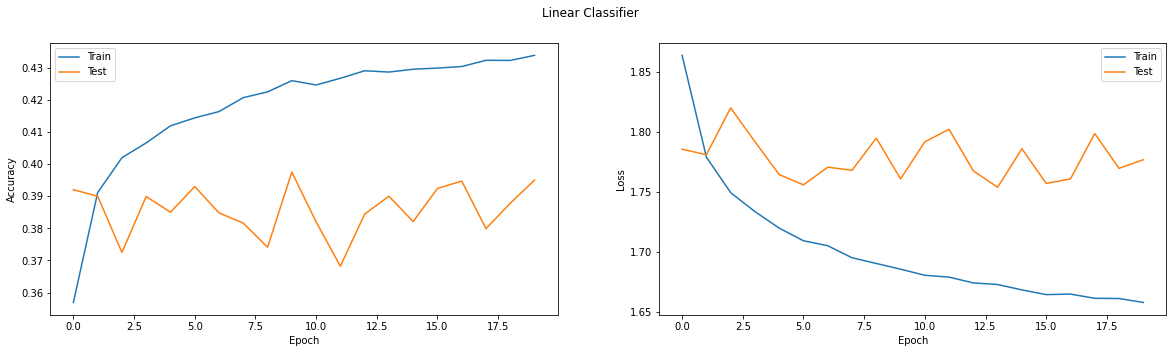

In [ ]:
plot_losses(train_losses_linear, 
            test_losses_linear, 
            train_accuracies_linear, 
            test_accuracies_linear,
            "Linear Classifier")

We can also have a look at some predictions of our model of the test set. The function `plot_predictions(dataloader, model_name, class_name=None)` plots predictions of of random images of the test set with our model. The input data should be a dataloader. By specifying the optional parameter class_name, only correct predictions, false positives and false negatives of this class will be plotted. Feel free to change the parameters below. In the image below you can see an example output of the function with the `class_name='horse'` for a different model.
**Edit 24.11.2021: You can now also set the paramter "sort_prediction = True" to get images with the highest predictions.**

![alt text](https://owncloud.tuwien.ac.at/index.php/apps/files_sharing/ajax/publicpreview.php?x=2193&y=855&a=true&file=horse_predictions.png&t=S2kIp8E9DGylCns&scalingup=0)


Number of correct recognized images: 5313
Number of wrong recognized images: 4687


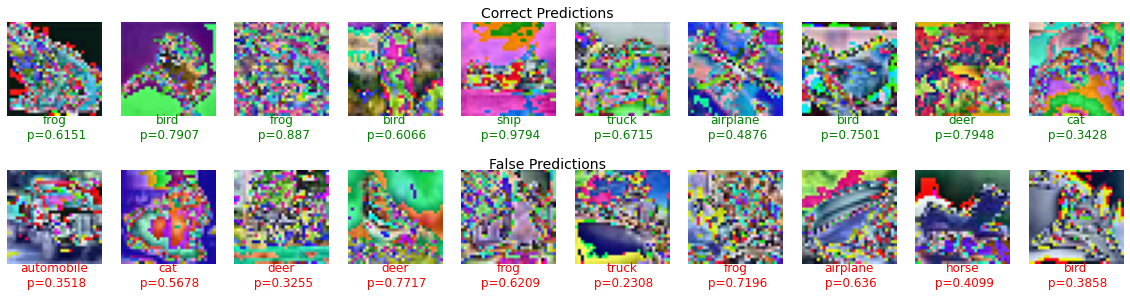

In [ ]:
plot_predictions(testloader, linear_model)

Number of correct recognized airplane images is 558
Number of images recognized as airplane but are not of that class is 807
Number of images not recognized as airplane but actually are of that class is 442


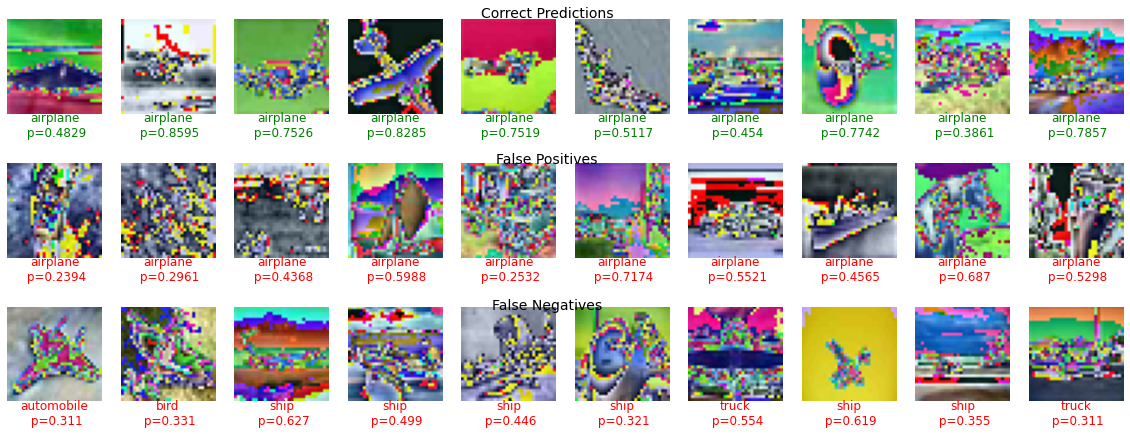

In [ ]:
plot_predictions(testloader, linear_model, class_name='airplane')

##5. Multilayer Perceptron (1 Point)
The last model with only one layer reached appr. 30% of validation accuracy. It is already better than random guessing but not really satisfactory. Now it's time to add the "Deep" to Deep Learning. Create a model with multiple dense layers (a multilayer perceptron) with ReLu activation in the hidden layers and train it again for about 30 Epochs. The exact structure of the model is up to you, a good starting point is a layer with 256 units, followed by another layer with 128 units and followed by the output layer. This model should reach around 50% of validation accuracy. Training time is dependent on your model but should be below 20s per epoch.

In [ ]:
# Implementation of a multilayer perceptron with 3 layers. It consists of 3 linear layers where finally has an output-size is 10

class MultiLayerPerceptron(nn.Module):
  def __init__(self):
    super(MultiLayerPerceptron, self).__init__()
    ###################################

    self.flatten = nn.Flatten()
    self.MLP = nn.Sequential(nn.Linear(32*32*3, 256),
                             nn.ReLU(),
                             nn.Linear(256, 128),
                             nn.ReLU(),
                             nn.Linear(128,10)
    )

    ###################################
  def forward(self, x):
    ###################################

    x = self.flatten(x)
    x = self.MLP(x)

    ###################################
    return x

# Initialize the model and Move it to the GPU if available
mlp_model = MultiLayerPerceptron().to(device)


# Adjust these parameters if necessary
epochs = 30
learning_rate = 0.01


# As an optimizer we use Stochastic Gradient Descent
optimizer_mlp = torch.optim.SGD(mlp_model.parameters(), lr=learning_rate)

loss_fn_mlp = nn.CrossEntropyLoss()

In [ ]:
# Actual Training

# Run the test_loop once to verify our model is not trained already
test_loop(testloader, mlp_model, loss_fn_mlp)

# Lists to log the losses during the training process
train_losses_mlp = []
train_accuracies_mlp = []

test_losses_mlp = []
test_accuracies_mlp = []

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss, train_acc = train_loop(trainloader, 
                                     mlp_model, 
                                     loss_fn_mlp, 
                                     optimizer_mlp)
  
  test_loss, test_acc = test_loop(testloader, 
                                  mlp_model, 
                                  loss_fn_mlp)
  
  train_losses_mlp.append(train_loss)
  train_accuracies_mlp.append(train_acc)

  test_losses_mlp.append(test_loss)
  test_accuracies_mlp.append(test_acc)
print("Done!")

Test Error: 
 Accuracy: 10.5%, Avg loss: 2.297499 

Epoch 1
-------------------------------
loss: 2.309544  [    0/50000]

loss: 2.134927  [12800/50000]

loss: 2.033504  [25600/50000]

loss: 1.894531  [38400/50000]

Test Error: 
 Accuracy: 35.6%, Avg loss: 1.843157 

Epoch 2
-------------------------------
loss: 1.786225  [    0/50000]

loss: 1.694956  [12800/50000]

loss: 1.725296  [25600/50000]

loss: 1.699617  [38400/50000]

Test Error: 
 Accuracy: 40.7%, Avg loss: 1.692698 

Epoch 3
-------------------------------
loss: 1.651312  [    0/50000]

loss: 1.538441  [12800/50000]

loss: 1.563840  [25600/50000]

loss: 1.631680  [38400/50000]

Test Error: 
 Accuracy: 43.9%, Avg loss: 1.614646 

Epoch 4
-------------------------------
loss: 1.728164  [    0/50000]

loss: 1.615130  [12800/50000]

loss: 1.636349  [25600/50000]

loss: 1.526972  [38400/50000]

Test Error: 
 Accuracy: 45.8%, Avg loss: 1.558997 

Epoch 5
-------------------------------
loss: 1.584477  [    0/50000]

loss: 1.55842

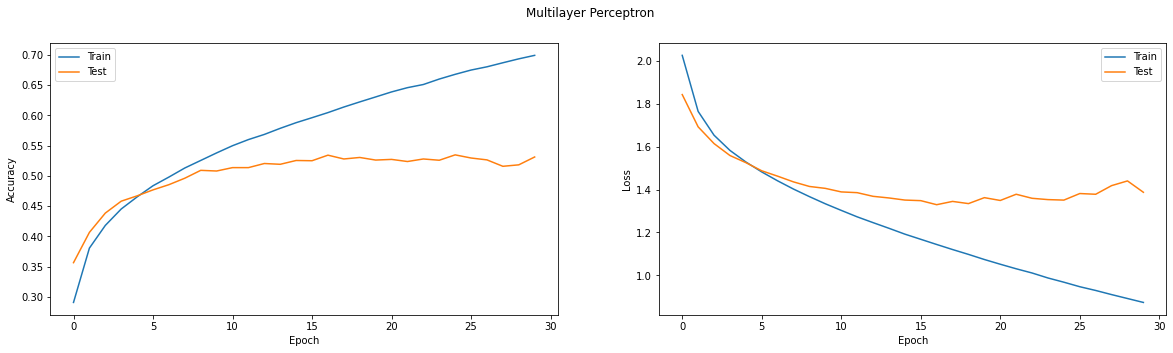

In [ ]:
plot_losses(train_losses_mlp, 
            test_losses_mlp, 
            train_accuracies_mlp, 
            test_accuracies_mlp,
            "Multilayer Perceptron")

## 6. MLP with Regularization (1 Point)
To counter the problem of overfitting, you should add measures for regularization. Create a new model based on your MLP from the last point which includes at least one regularization technique. It should improve the validation accuracy slightly.

In [ ]:
# Simple implementation of a multilayer perceptron (the sames as before), but
# Here I've added a regulization technique (dropout in this case) to combat
# overfitting. I used p=0.3 here to achieve the desired accuracy. 

class MultiLayerPerceptronRegularization(nn.Module):
  def __init__(self):
    super(MultiLayerPerceptronRegularization, self).__init__()
    ###################################

    self.flatten = nn.Flatten()
    self.MLPR = nn.Sequential(nn.Linear(32*32*3, 256),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(256, 128),
                             nn.ReLU(),
                             nn.Dropout(p=0.2), 
                             nn.Linear(128,10)
    )


    ###################################
  def forward(self, x):
    ###################################
    
    x = self.flatten(x)
    x = self.MLPR(x)

    ###################################
    return x


# Initialize model and move to the GPU if available
mlp_model_reg = MultiLayerPerceptronRegularization().to(device)

# Adjust these parameters if necessary
epochs = 30
learning_rate = 0.01

# As an optimizer we use Stochastic Gradient Descent.
# You can change its parameters here
optimizer_mlp_reg = torch.optim.SGD(mlp_model_reg.parameters(), lr=learning_rate)

In [ ]:
# Actual Training

# Define the loss function
loss_fn_mlp_reg = nn.CrossEntropyLoss()

# As an optimizer we use Stochastic Gradient Descent
optimizer_mlp_reg = torch.optim.SGD(mlp_model_reg.parameters(), 
                                    lr=learning_rate)

# Run the test_loop once to verify our model is not trained already
test_loop(testloader, mlp_model_reg, loss_fn_mlp_reg)

# Lists to log the losses during the training process
train_losses_mlp_reg = []
train_accuracies_mlp_reg = []

test_losses_mlp_reg = []
test_accuracies_mlp_reg = []

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss, train_acc = train_loop(trainloader, 
                                     mlp_model_reg, 
                                     loss_fn_mlp_reg, 
                                     optimizer_mlp_reg)
  test_loss, test_acc = test_loop(testloader, 
                                  mlp_model_reg, 
                                  loss_fn_mlp_reg)
  
  train_losses_mlp_reg.append(train_loss)
  train_accuracies_mlp_reg.append(train_acc)

  test_losses_mlp_reg.append(test_loss)
  test_accuracies_mlp_reg.append(test_acc)
print("Done!")

Test Error: 
 Accuracy: 8.9%, Avg loss: 2.314539 

Epoch 1
-------------------------------
loss: 2.313165  [    0/50000]

loss: 2.171185  [12800/50000]

loss: 2.039873  [25600/50000]

loss: 2.003636  [38400/50000]

Test Error: 
 Accuracy: 31.3%, Avg loss: 1.926974 

Epoch 2
-------------------------------
loss: 1.980293  [    0/50000]

loss: 2.054160  [12800/50000]

loss: 1.875409  [25600/50000]

loss: 1.890955  [38400/50000]

Test Error: 
 Accuracy: 36.1%, Avg loss: 1.807504 

Epoch 3
-------------------------------
loss: 1.841368  [    0/50000]

loss: 1.683851  [12800/50000]

loss: 1.920911  [25600/50000]

loss: 1.897647  [38400/50000]

Test Error: 
 Accuracy: 38.0%, Avg loss: 1.752240 

Epoch 4
-------------------------------
loss: 1.691095  [    0/50000]

loss: 1.700605  [12800/50000]

loss: 1.720318  [25600/50000]

loss: 1.734161  [38400/50000]

Test Error: 
 Accuracy: 39.1%, Avg loss: 1.704662 

Epoch 5
-------------------------------
loss: 1.869101  [    0/50000]

loss: 1.611354

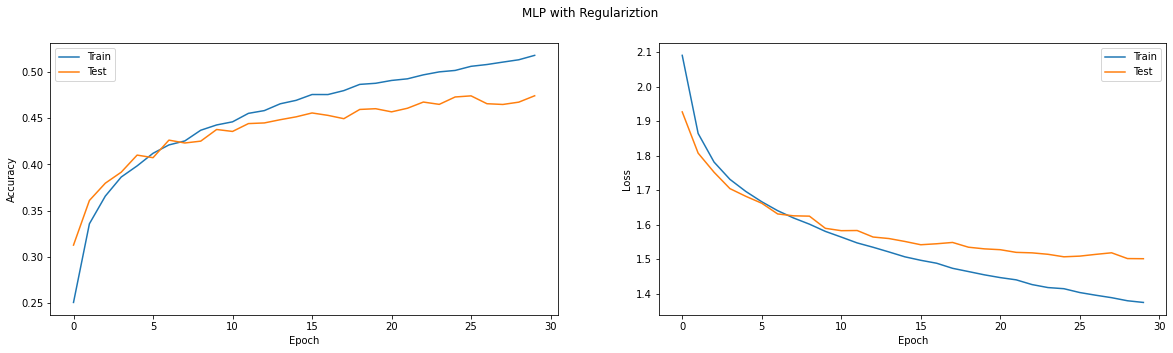

In [ ]:
plot_losses(train_losses_mlp_reg, 
            test_losses_mlp_reg, 
            train_accuracies_mlp_reg, 
            test_accuracies_mlp_reg,
            "MLP with Regulariztion")

## 7. Convolutional Neural Network (1 Point)
When converting our images to vectors, all spatial information is lost. A convolutional neural network takes tensors as input and computes features that make use of spatial information. In this exercise implement a neural network as specified in the image below. Add regularization techniques until you reach at least 75% of validation accuracy with a training time of below 30s per epoch.

Notes: 3x3 Conv X refers to a Conv2D layer with kernel 3x3 and X units. 
Maxpool /2 refers to a MaxPool layer with kernel=(2,2) and stride=2.


![Network Architecture](https://owncloud.tuwien.ac.at/index.php/apps/files_sharing/ajax/publicpreview.php?x=3360&y=1178&a=true&file=CNN-architecture.png&t=Ms797G0SEXgeZZe&scalingup=0)

Figure 3: Network Architecture

---

In [ ]:
# Here we have my implementation of the illustrated CNN in figure 3

class CNNClassifier(nn.Module):
  def __init__(self):
    super(CNNClassifier, self).__init__()
    ###################################

    self.flatten = nn.Flatten()
    self.gap = nn.AvgPool2d(2)
    self.lin = nn.Linear(4*128, 10)
    self.CNNC = nn.Sequential(nn.Conv2d(3, 32, 3), # Here we have 3*3 Conv 32
                             nn.ReLU(),
                             nn.Dropout(p=0.3), # Applying dropout to achieve sufficient accuracy
                             nn.MaxPool2d(2), # Maxpooling with kernel 2*2 and stride = 2
                             nn.Conv2d(32, 64, 3), # Here we have 3*3 Conv 64
                             nn.ReLU(),
                             nn.Dropout(p=0.3), # Applying dropout to achieve sufficient accuracy 
                             nn.MaxPool2d(2), # Maxpooling with kernel 2*2 and stride = 2
                             nn.Conv2d(64, 128, 3), # Here we have 3*3 Conv 128
                             nn.ReLU(),
                             nn.Dropout(p=0.3)  #Applying dropout to achieve sufficient accuracy                           
    )

    ###################################
  def forward(self, x):
    ###################################

    x = self.CNNC(x)
    x = self.gap(x)
    x = self.flatten(x)
    x = self.lin(x)

    ###################################
    return x

# Initialize the model and Move it to the GPU if available
cnn_model = CNNClassifier().to(device)

# Adjust these parameters if necessary
epochs = 30
learning_rate = 0.001

# As an optimizer we use Adam
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)



In [ ]:
# Actual Training

# Define the loss function
loss_fn_cnn = nn.CrossEntropyLoss()

# Run the test_loop once to verify our model is not trained already
test_loop(testloader, 
          cnn_model, 
          loss_fn_cnn)

# Lists to log the losses during the training process
train_losses_cnn = []
train_accuracies_cnn = []

test_losses_cnn = []
test_accuracies_cnn = []

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss, train_acc = train_loop(trainloader, 
                                     cnn_model, 
                                     loss_fn_cnn, 
                                     optimizer_cnn)
  test_loss, test_acc = test_loop(testloader, 
                                  cnn_model, 
                                  loss_fn_cnn)
  
  train_losses_cnn.append(train_loss)
  train_accuracies_cnn.append(train_acc)

  test_losses_cnn.append(test_loss)
  test_accuracies_cnn.append(test_acc)
print("Done!")

In [ ]:
plot_losses(train_losses_cnn, 
            test_losses_cnn, 
            train_accuracies_cnn, 
            test_accuracies_cnn,
            "CNN random brightness")

## 8. Data Augmentation (1 Point)
A possibility to increase the performance of our classifier is to artificially increase the size of the training dataset. This can be done through data augmentation which is a technique where you create slightly modified copies of the input data. An example would be to flip (mirror) images along an axis or slightly changing the brightness. PyTorch provides many functions for this technique in `pytorch.transforms` (https://pytorch.org/vision/stable/transforms.html). 

Implement a new trainloader which applies data augmentation and use it to train a new model based on `CNNClassifier`. Compare at least two data augmentation techniques for the report. Don't expect big performance gains, since the CIFAR10 dataset is rather simple and some augmentation techniques won't work well due to the small image resolution. We don't provide a template for this part, just use the cell below to implement the `trainloader`, and train a model with it.  

In [ ]:
###################################

bright = True # simple variable to control which data augmentation technique is used further down

# Here I redefine the trainset and add that the brightness of the images will be altered at random

trainset_bright = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=False,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.ColorJitter(brightness=0.5),   
                                                                      transforms.Normalize((0.49139968, 0.48215827, 0.44653124), 
                                                                                            (0.24703233, 0.24348505, 0.26158768))]))

trainloader_bright = torch.utils.data.DataLoader(trainset_bright, 
                                          batch_size=128,
                                          shuffle=True, 
                                          pin_memory = True, 
                                          num_workers=2)

# Here I redefine the trainset and add that images will be flipped horizontally at random

trainset_flip = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=False,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.RandomHorizontalFlip(), 
                                                                      transforms.Normalize((0.49139968, 0.48215827, 0.44653124), 
                                                                                            (0.24703233, 0.24348505, 0.26158768))]))

trainloader_flip = torch.utils.data.DataLoader(trainset_flip, 
                                          batch_size=128,
                                          shuffle=True, 
                                          pin_memory = True, 
                                          num_workers=2)

# Training the CNN-model with our augmented trainloaders. The functions and the methodsare identical to the once you've 
# defined earlier in the colab-file.

loss_fn_cnn = nn.CrossEntropyLoss()

# Run the test_loop once to verify our model is not trained already
test_loop(testloader, 
          cnn_model, 
          loss_fn_cnn)

# Lists to log the losses during the training process
train_losses_cnn = []
train_accuracies_cnn = []

test_losses_cnn = []
test_accuracies_cnn = []

if bright: # Here I just use my predefined variable to swithc between my two augmented trainloaders

# The training process itself

  for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(trainloader_bright, 
                                       cnn_model, 
                                       loss_fn_cnn, 
                                       optimizer_cnn)
    test_loss, test_acc = test_loop(testloader, 
                                    cnn_model, 
                                    loss_fn_cnn)
  
    train_losses_cnn.append(train_loss)
    train_accuracies_cnn.append(train_acc)

    test_losses_cnn.append(test_loss)
    test_accuracies_cnn.append(test_acc)
  print("Done!")

else:

# The training process itself

  for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(trainloader_flip, 
                                       cnn_model, 
                                       loss_fn_cnn, 
                                       optimizer_cnn)
    test_loss, test_acc = test_loop(testloader, 
                                    cnn_model, 
                                    loss_fn_cnn)
  
    train_losses_cnn.append(train_loss)
    train_accuracies_cnn.append(train_acc)

    test_losses_cnn.append(test_loss)
    test_accuracies_cnn.append(test_acc)

  print("Done!")

###################################

##9. Finetuning (1 Point)
In the next step we want to use a model which is already pre-trained on a large dataset (Imagenet) and finetune it for the CIFAR10 dataset. PyTorch already provides us with multiple pretrained models (see https://pytorch.org/vision/stable/models.html). Your task is to take the ResNet50 model and **only** retrain the last layer. You should upsample the images first because ResNet is trained on Images with the resolution of (224, 224). Training with this resolution takes a substantial amount of time with not that much gain. A resolution of (128, 128) is a good compromise between accuracy and training time. You can use the `Resize` transform from `pytorch.transforms`. You should also normalize the images the same way as ResNet does. This approach should get you to over 80% of validation accuracy. Training time will take much longer here (~120 seconds per epoch), so you only need to train for 5-10 epochs. We won't provide a template for this part again, just add the code for loading the model,  exchanging the last layer and training it in the cell below.

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Test Error: 
 Accuracy: 8.1%, Avg loss: 2.376981 

Epoch 1
-------------------------------
loss: 2.421281  [    0/50000]

loss: 0.691874  [12800/50000]

loss: 0.581222  [25600/50000]

loss: 0.661181  [38400/50000]

Test Error: 
 Accuracy: 81.6%, Avg loss: 0.551739 

Done!
Epoch 2
-------------------------------
loss: 0.636041  [    0/50000]

loss: 0.610184  [12800/50000]

loss: 0.626117  [25600/50000]

loss: 0.546706  [38400/50000]

Test Error: 
 Accuracy: 82.2%, Avg loss: 0.522209 

Done!
Epoch 3
-------------------------------
loss: 0.428937  [    0/50000]

loss: 0.461309  [12800/50000]

loss: 0.436851  [25600/50000]

loss: 0.474538  [38400/50000]

Test Error: 
 Accuracy: 82.7%, Avg loss: 0.507284 

Done!
Epoch 4
-------------------------------
loss: 0.502502  [    0/50000]

loss: 0.468352  [12800/50000]

loss: 0.348768  [25600/50000]

loss: 0.462394  [38400/50000]

Test Error: 
 Accuracy: 83.2%, Avg loss: 0.495283 

Done!
Epoch 5
-------------------------------
loss: 0.440138  [    

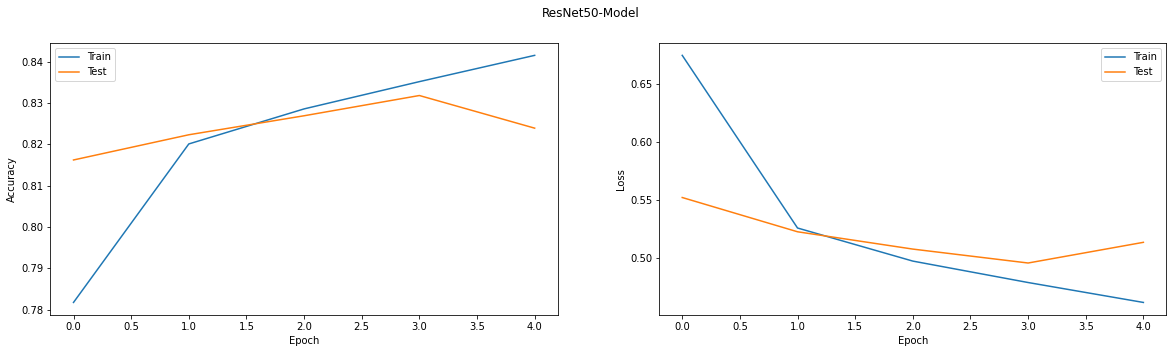

In [ ]:
#@title
from torchvision import models
###################################

epochs = 5
learning_rate = 0.001

# Redefines the trainset, trainloader, testset and testloader here so that it will
# normalize the ResNet50-model correctly as well as resizes it to 128*128.

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=False,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.Resize(size=128),   
                                                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])) 
                                      
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=128,
                                          shuffle=True, 
                                          pin_memory = True, 
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=False, 
                                       transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Resize(size=128),   
                                                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=1024,
                                         shuffle=False, 
                                         pin_memory = True, 
                                         num_workers=2)

# Here I download the model and also sets requires.grad to false to freeze the
# parameters in the model so that their gradients aren't calculated
# in the backward-step. 

resnet_model = torchvision.models.resnet50(pretrained=True)
for param in resnet_model.parameters():
  param.requires_grad = False

# Here I find the number of features in the final layer and use that as my nr.
# input-channels when I change the final layer to a linear layer with 10 outputs
# to acquire our predictions correctly. I also move the model to the gpu if possible

resnet_model_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(resnet_model_features, 10)
resnet_model.to(device)

loss_fn_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet_model.fc.parameters(), lr=learning_rate)

# Below follows the same training that you've defined earlier in this colab.

# Run the test_loop once to verify our model is not trained already
test_loop(testloader, 
          resnet_model, 
          loss_fn_resnet)

# Lists to log the losses during the training process
train_losses_resnet = []
train_accuracies_resnet = []

test_losses_resnet = []
test_accuracies_resnet = []

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss, train_acc = train_loop(trainloader, 
                                     resnet_model, 
                                     loss_fn_resnet, 
                                     optimizer_resnet)
  test_loss, test_acc = test_loop(testloader, 
                                  resnet_model, 
                                  loss_fn_resnet)
  
  train_losses_resnet.append(train_loss)
  train_accuracies_resnet.append(train_acc)

  test_losses_resnet.append(test_loss)
  test_accuracies_resnet.append(test_acc)
  print("Done!")

# Finally I plot the losses and accuracies from both the training and testing

plot_losses(train_losses_resnet, 
            test_losses_resnet, 
            train_accuracies_resnet, 
            test_accuracies_resnet,
            "ResNet50-Model")

###################################

# Experiments
Here you can add code that you need for your documentation. Feel free to play around in this section with the models, your own images, create new models, data augmentation, different datasets, ...



In [ ]:
# Load an image from that link and get Top-5 predictions
test_im = load_image_link('https://www.rp-assets.com/images/news/2019/03/17/58275-medium.jpeg')
plt.imshow(test_im[0,...])
test_im = normalize_images(X_train, test_im)[1]
#vec_im = vectorize_images(test_im)
predict_image(cnn_model, test_im)


In [ ]:
# If you want to mount your Google Drive to store weights or plots for example
# you can use the commands below. Check this link for more information:
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA
from google.colab import drive
drive.mount('/content/drive')